In [39]:
# Import calibration functions
# Run this to reimport without having to restart the whole notebook
import radial_velocity_functions
import importlib
importlib.reload(radial_velocity_functions)
from radial_velocity_functions import *

In [32]:
# plt styles
matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.size"] = 10 
matplotlib.rcParams['figure.dpi'] = 100

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm as tqdm
from tqdm import tqdm
import pandas as pd
from datetime import datetime
from scipy.interpolate import interp1d

# plt styles
matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.size"] = 10 
matplotlib.rcParams['figure.dpi'] = 300

from os import walk

### Matrix and fit for non-bary-centric data to show earth movement and the usage of the matrix reduction

In [8]:
filename = "lily_data_results/all_features_34411_ms_non_bary.npy"
result, coords = np.load(filename, allow_pickle=True)
result = filter_z_test_result(result)
diff_matrix, diff_matrix_err, diff_matrix_valid = parse_matrix_results(result, coords)
m, final_shifts, final_shifts_err, days = matrix_reduce_results_file(filename, SPECTRA_PATH_34411, plot=False)

/Users/jakobharteg/GitHub/bachelor-project/radial_velocity_functions.py:796: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  shift_mean, shift_mean_err = weighted_mean(shifts_list[shifts_valid_list == 1], shifts_err_list[[shifts_valid_list == 1]])


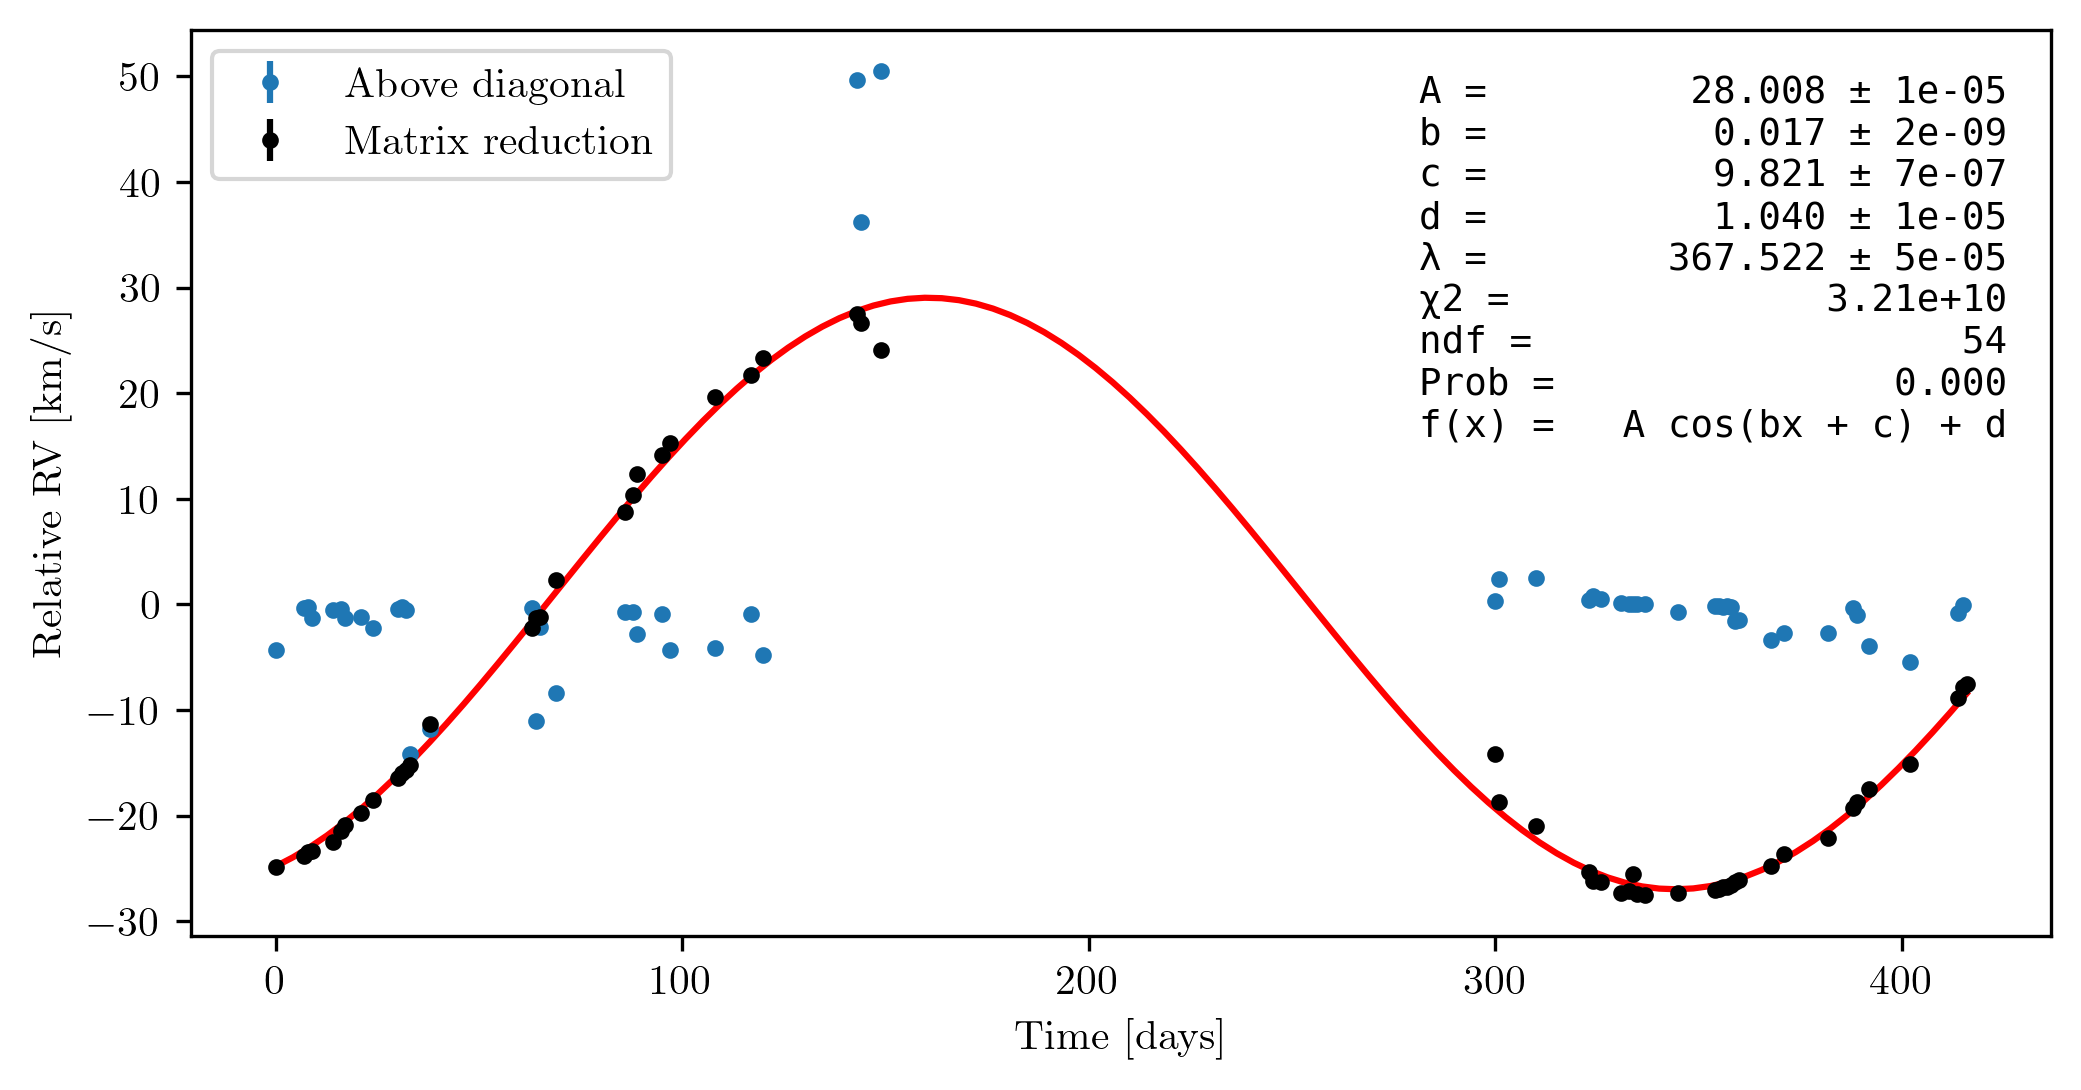

In [9]:
c = 299792458

# The velocity shifts are between days, so let's put the x-error bar as the time span for each data point
velocity_shifts = get_above_diagonal(diff_matrix) * 1/1000 # km/s
velocity_shifts_err = get_above_diagonal(diff_matrix_err) * 1/1000 # km/s
dates = get_spectra_dates(get_spectra_filenames_without_duplicate_dates())
days = convert_dates_to_relative_days(dates)

fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 4))

ax1.set_xlabel("Time [days]")
ax1.set_ylabel("Relative RV [km/s]")
ax1.errorbar(days[:-1], velocity_shifts, yerr=velocity_shifts_err, fmt=".", color="C0", label="Above diagonal")

# Fit
x = days
y = np.asarray(final_shifts[:]) * 1/1000 # km/s
y_err = np.asarray(final_shifts_err[:]) * 1/1000 # km/s
ax1.errorbar(x, y, yerr=y_err, fmt=".", color="k", label="Matrix reduction")

# Fitting functions:
def func(x, a, b, c, d) :
    return a * np.cos(x * b + c) + d


# ChiSquare fit model:
def model_chi(a, b, c, d) :
    y_fit = func(x, a, b, c, d)
    chi2 = np.sum(((y - y_fit) / y_err)**2)
    return chi2
model_chi.errordef = 1

minuit = Minuit(model_chi, a=30000, b=0.01, c=3.5, d=1040)
m = minuit.migrad()        
                    
# Plot result
xPeak = np.linspace(x[0], x[len(x)-1], 100)
ax1.plot(xPeak, func(xPeak, *minuit.values[:]), '-r')

Npoints = len(x)
Nvar = 4                                        # Number of variables
Ndof_fit = Npoints - Nvar                       # Number of degrees of freedom = Number of data points - Number of variables
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

a, a_err = minuit.values['a'], minuit.errors['a']
b, b_err = minuit.values['b'], minuit.errors['b']
c, c_err = minuit.values['c'], minuit.errors['c']
d, d_err = minuit.values['d'], minuit.errors['d']
wavel, wavel_err = (2 * np.pi)/b, np.sqrt((2 * np.pi)**2*b_err**2/b**4)

d = {'A = ':   [a, f"{a_err:.1}"],
    'b = ':    [b, f"{b_err:.1}"],
    'c = ':    [c, f"{c_err:.1}"],
    'd = ':    [d, f"{d_err:.1}"],
    'λ = ':    [wavel, f"{wavel_err:.1}"],
    'χ2 = ':     f"{Chi2_fit:.3}",
    'ndf = ':      Ndof_fit,
    'Prob = ':     Prob_fit,
    'f(x) = ':     "A cos(bx + c) + d"
}

matplotlib.rcParams["text.usetex"] = False
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.66, 0.95, text, ax1, fontsize=9, color='black')
matplotlib.rcParams["text.usetex"] = True
ax1.legend(loc = "upper left")

# fig.savefig("shift_non_bary_centric.pdf", bbox_inches="tight", dpi=300)

### Comparison with Lily's results

In [5]:
# file = "lily_data_results/all_features_34411_ms_bary.npy"
# file = "lily_data_results/all_features_match2_34411_ms_bary.npy"
# file = "lily_data_results/all_features_all_obs_34411_ms_non_bary.npy"
file = "lily_data_results/all_features_match2_all_files_34411_ms_bary.npy"
result, coords = np.load(file, allow_pickle=True)
result = filter_z_test_result(result)
# plot_matrix(*parse_matrix_results(result, coords), plot_ratio=True)
m, final_shifts, final_shifts_err, days = matrix_reduce_results_file(file, path=SPECTRA_PATH_34411, plot=False, with_date_duplicates=True)

/Users/jakobharteg/GitHub/bachelor-project/radial_velocity_functions.py:824: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  shift_mean, shift_mean_err = weighted_mean(shifts_list[shifts_valid_list == 1], shifts_err_list[[shifts_valid_list == 1]])


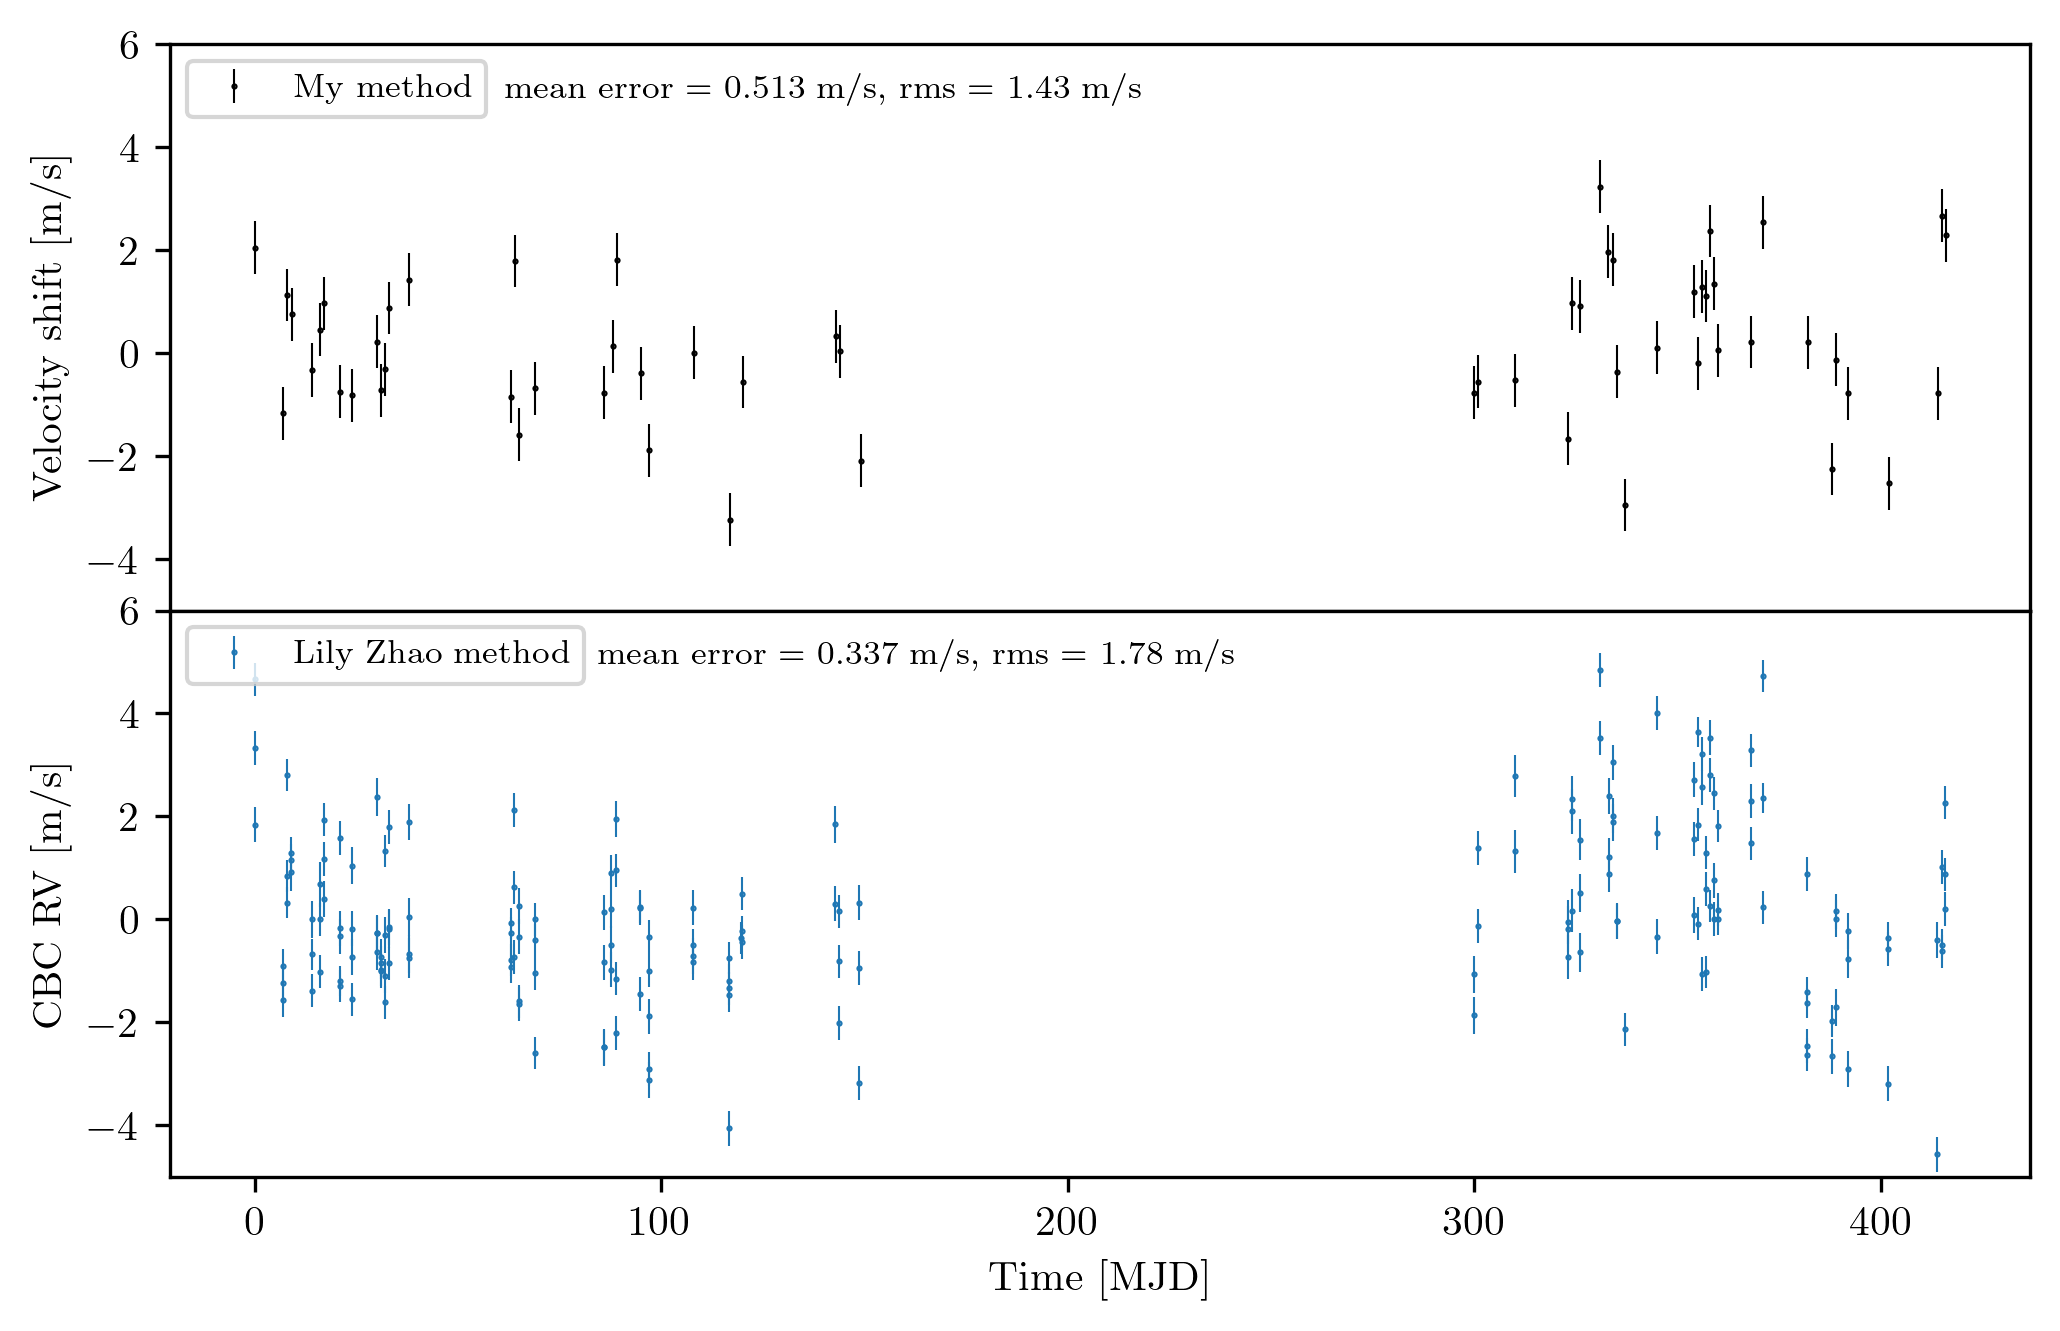

In [20]:
def plot_compare_lily(my_rv, my_err, days):
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8, 5), sharex=True)

    ax1.set_ylabel("Velocity shift [m/s]")
    ax1.errorbar(days, my_rv, yerr=my_err, fmt=".", color="k", ms=1, elinewidth=0.5, label="My method")
    ax1.set_ylim(-5, 6)
    ax1.legend(loc="upper left", prop={'size': 8})
    text = f"mean error = {np.mean(my_err):.3} m/s, rms = {(compute_rms(my_rv)):.3} m/s"
    ax1.text(0.18, 0.95, text,
                        size = 8,
                        horizontalalignment='left',
                        verticalalignment='top',
                        transform=ax1.transAxes)

    df = pd.read_csv("lily_stellar_activity_data/34411_activity.csv")
    rv = df["CBC RV [m/s]"]
    rv_err = df["CBC RV Err. [m/s]"]
    t = df["Time [MJD]"]
    t = t - min(t)
    rms2 = compute_rms(rv)

    ax2.errorbar(t, rv, yerr=rv_err, fmt=".", ms=1, elinewidth=0.5, label="Lily Zhao method")
    ax2.set_xlabel("Time [MJD]")
    ax2.set_ylabel("CBC RV [m/s]")
    ax2.set_ylim(-5, 6)
    ax2.legend(loc="upper left", prop={'size': 8})

    text = f"mean error = {np.mean(rv_err):.3} m/s, rms = {(rms2):.3} m/s"
    ax2.text(0.23, 0.95, text,
                        size = 8,
                        horizontalalignment='left',
                        verticalalignment='top',
                        transform=ax2.transAxes)

    # ax1.get_shared_x_axes().join(ax1, ax2)

    ax1.sharex(ax2)
    fig.subplots_adjust(wspace=0, hspace=0)
    # fig.tight_layout()

    # fig.savefig("HD34411_barycentric_rv_vs_lily.pdf", bbox_inches="tight", dpi=300)

    # Histogram of residuals if same length
    if len(rv) == len(my_rv):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6,1.5))
        ax1.hist(final_shifts - rv, bins=50, range=(-5, 5));
        ax2.scatter(final_shifts, rv, s=0.5)


plot_compare_lily(final_shifts, final_shifts_err, days)

### Comparison with Lily (Chauvenet's plus weighted mean)

In [49]:
file = "lily_data_results/all_features_match2_all_files_34411_ms_bary.npy"
result, coords = np.load(file, allow_pickle=True)
filter_result = remove_outliers_from_result_with_chauvenet(result)
matrix = parse_matrix_results(filter_result, coords, median_err=True, use_median=True)
m, final_shifts, final_shifts_err, days = matrix_reduce(*matrix, path=SPECTRA_PATH_34411, plot=False, with_date_duplicates=True)

/Users/jakobharteg/miniconda3/envs/bsc_project/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


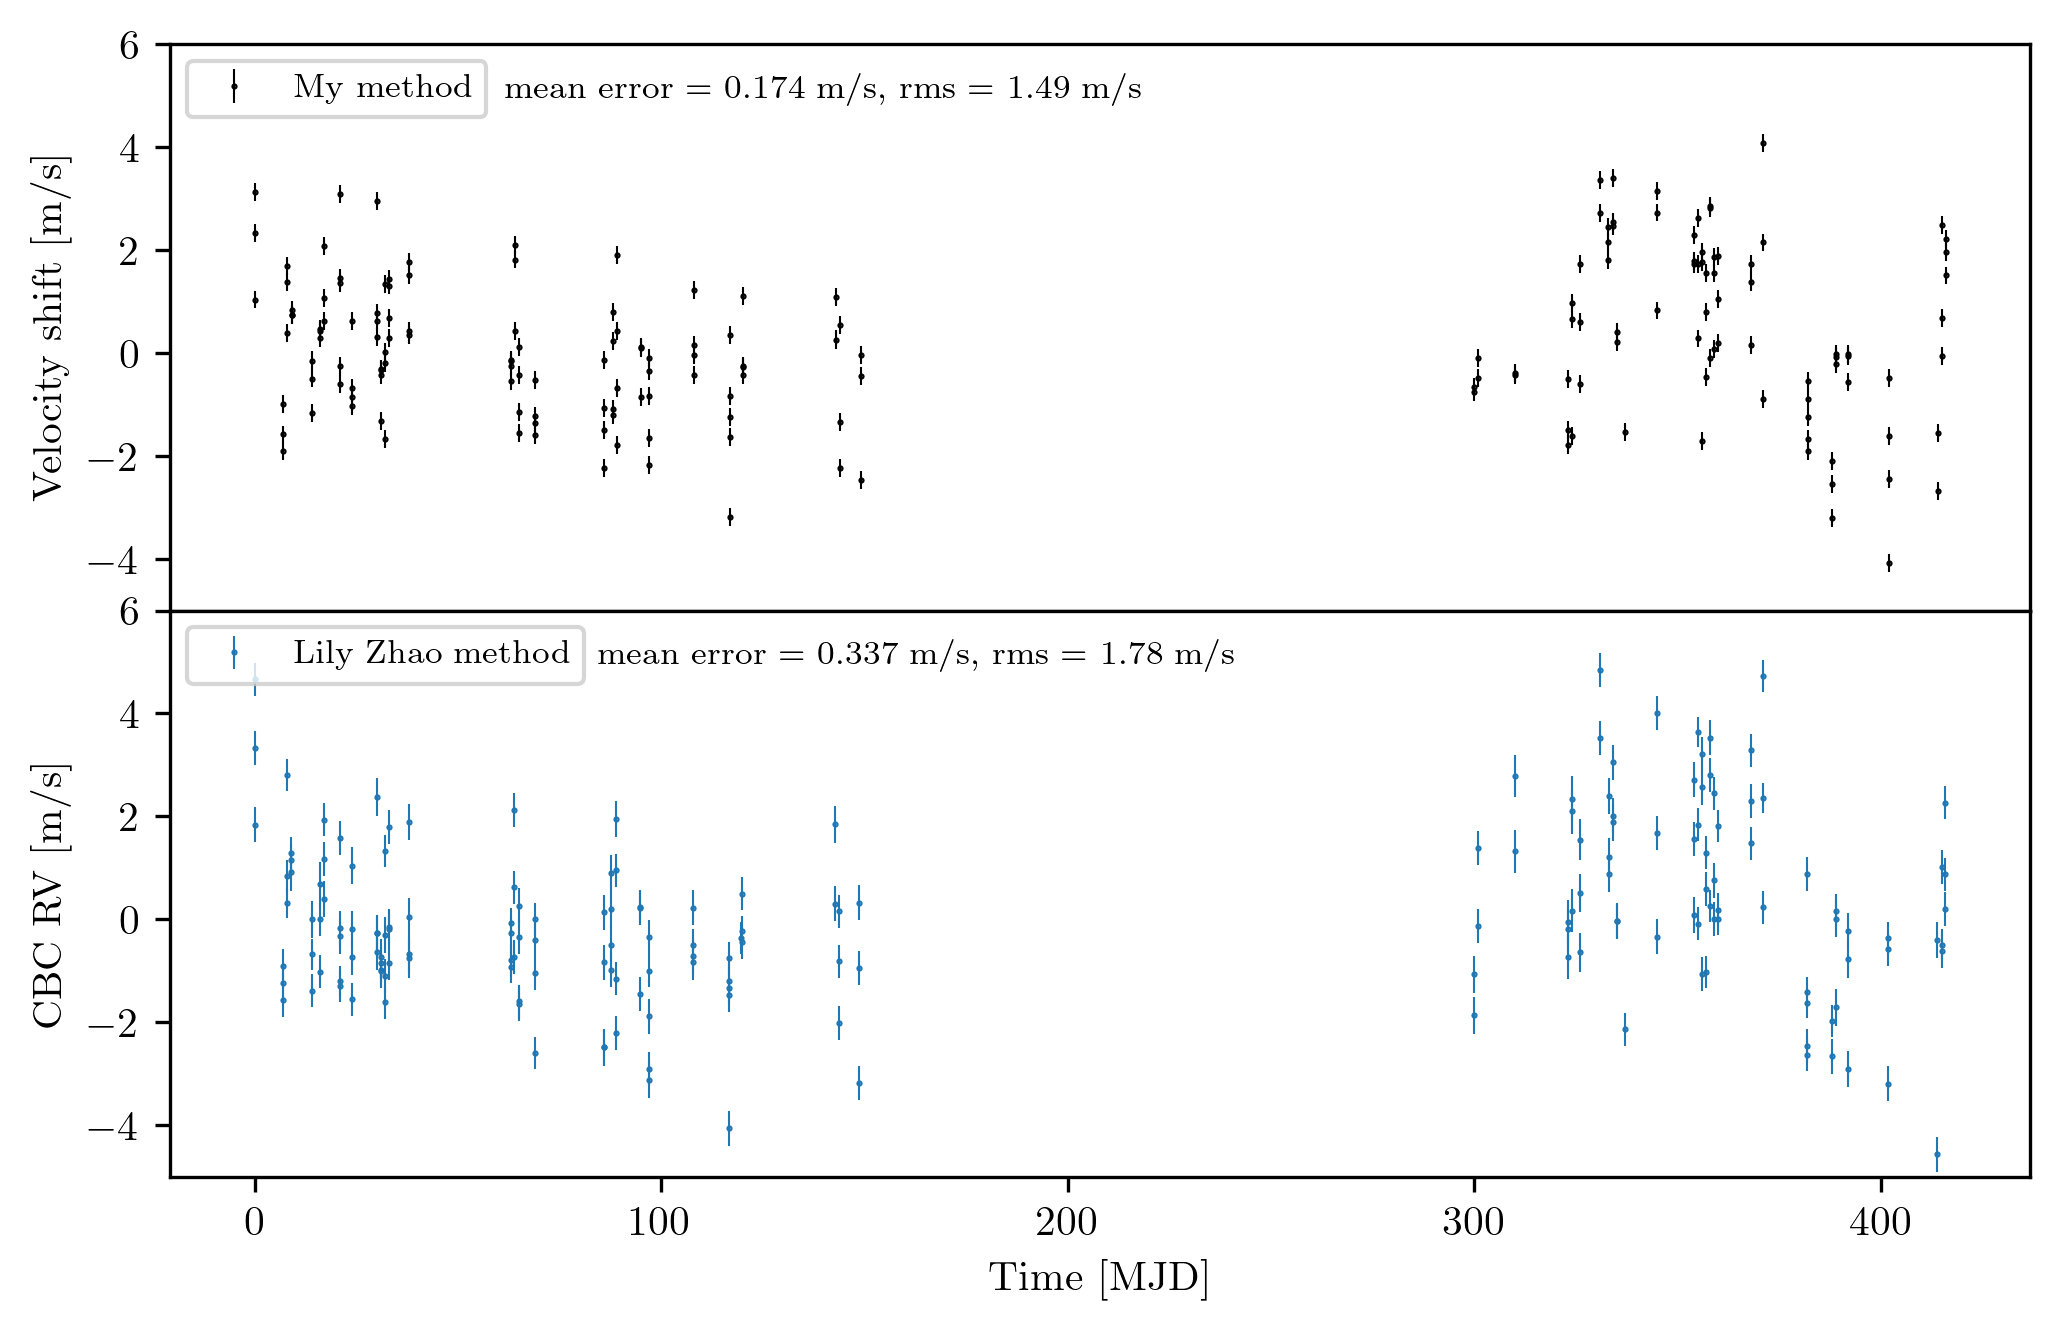

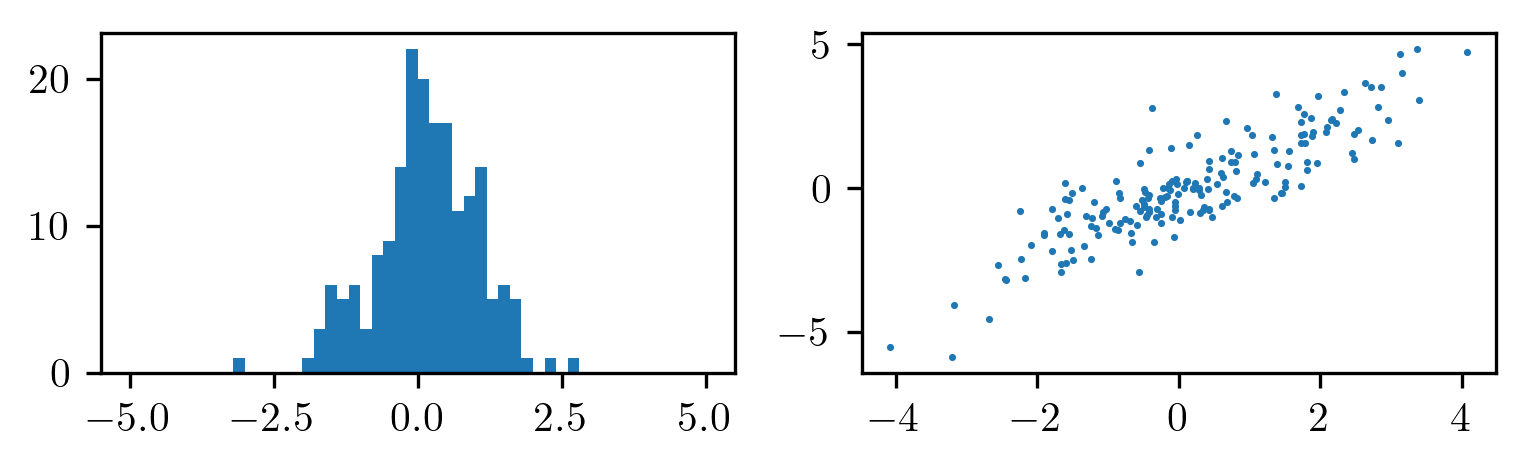

In [51]:
plot_compare_lily(final_shifts, final_shifts_err, days)

### Comparison with Lily (median + median err)

#### Chauvenet's criterion

In [52]:
# file = "lily_data_results/all_features_all_obs_34411_ms_non_bary.npy"
# file = "lily_data_results/34411_58_match2_ms_bary_err=sqrt1_dist=0.5_area=0.2.npy"
file = "lily_data_results/all_features_match2_all_files_34411_ms_bary.npy"
result, coords = np.load(file, allow_pickle=True)
filter_result = remove_outliers_from_result_with_chauvenet(result)
matrix = parse_matrix_results(filter_result, coords, median_err=True)
# plot_matrix(*parse_matrix_results(result, coords), plot_ratio=True)
m, final_shifts, final_shifts_err, days = matrix_reduce(*matrix, path=SPECTRA_PATH_34411, plot=False, with_date_duplicates=True)

/Users/jakobharteg/miniconda3/envs/bsc_project/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


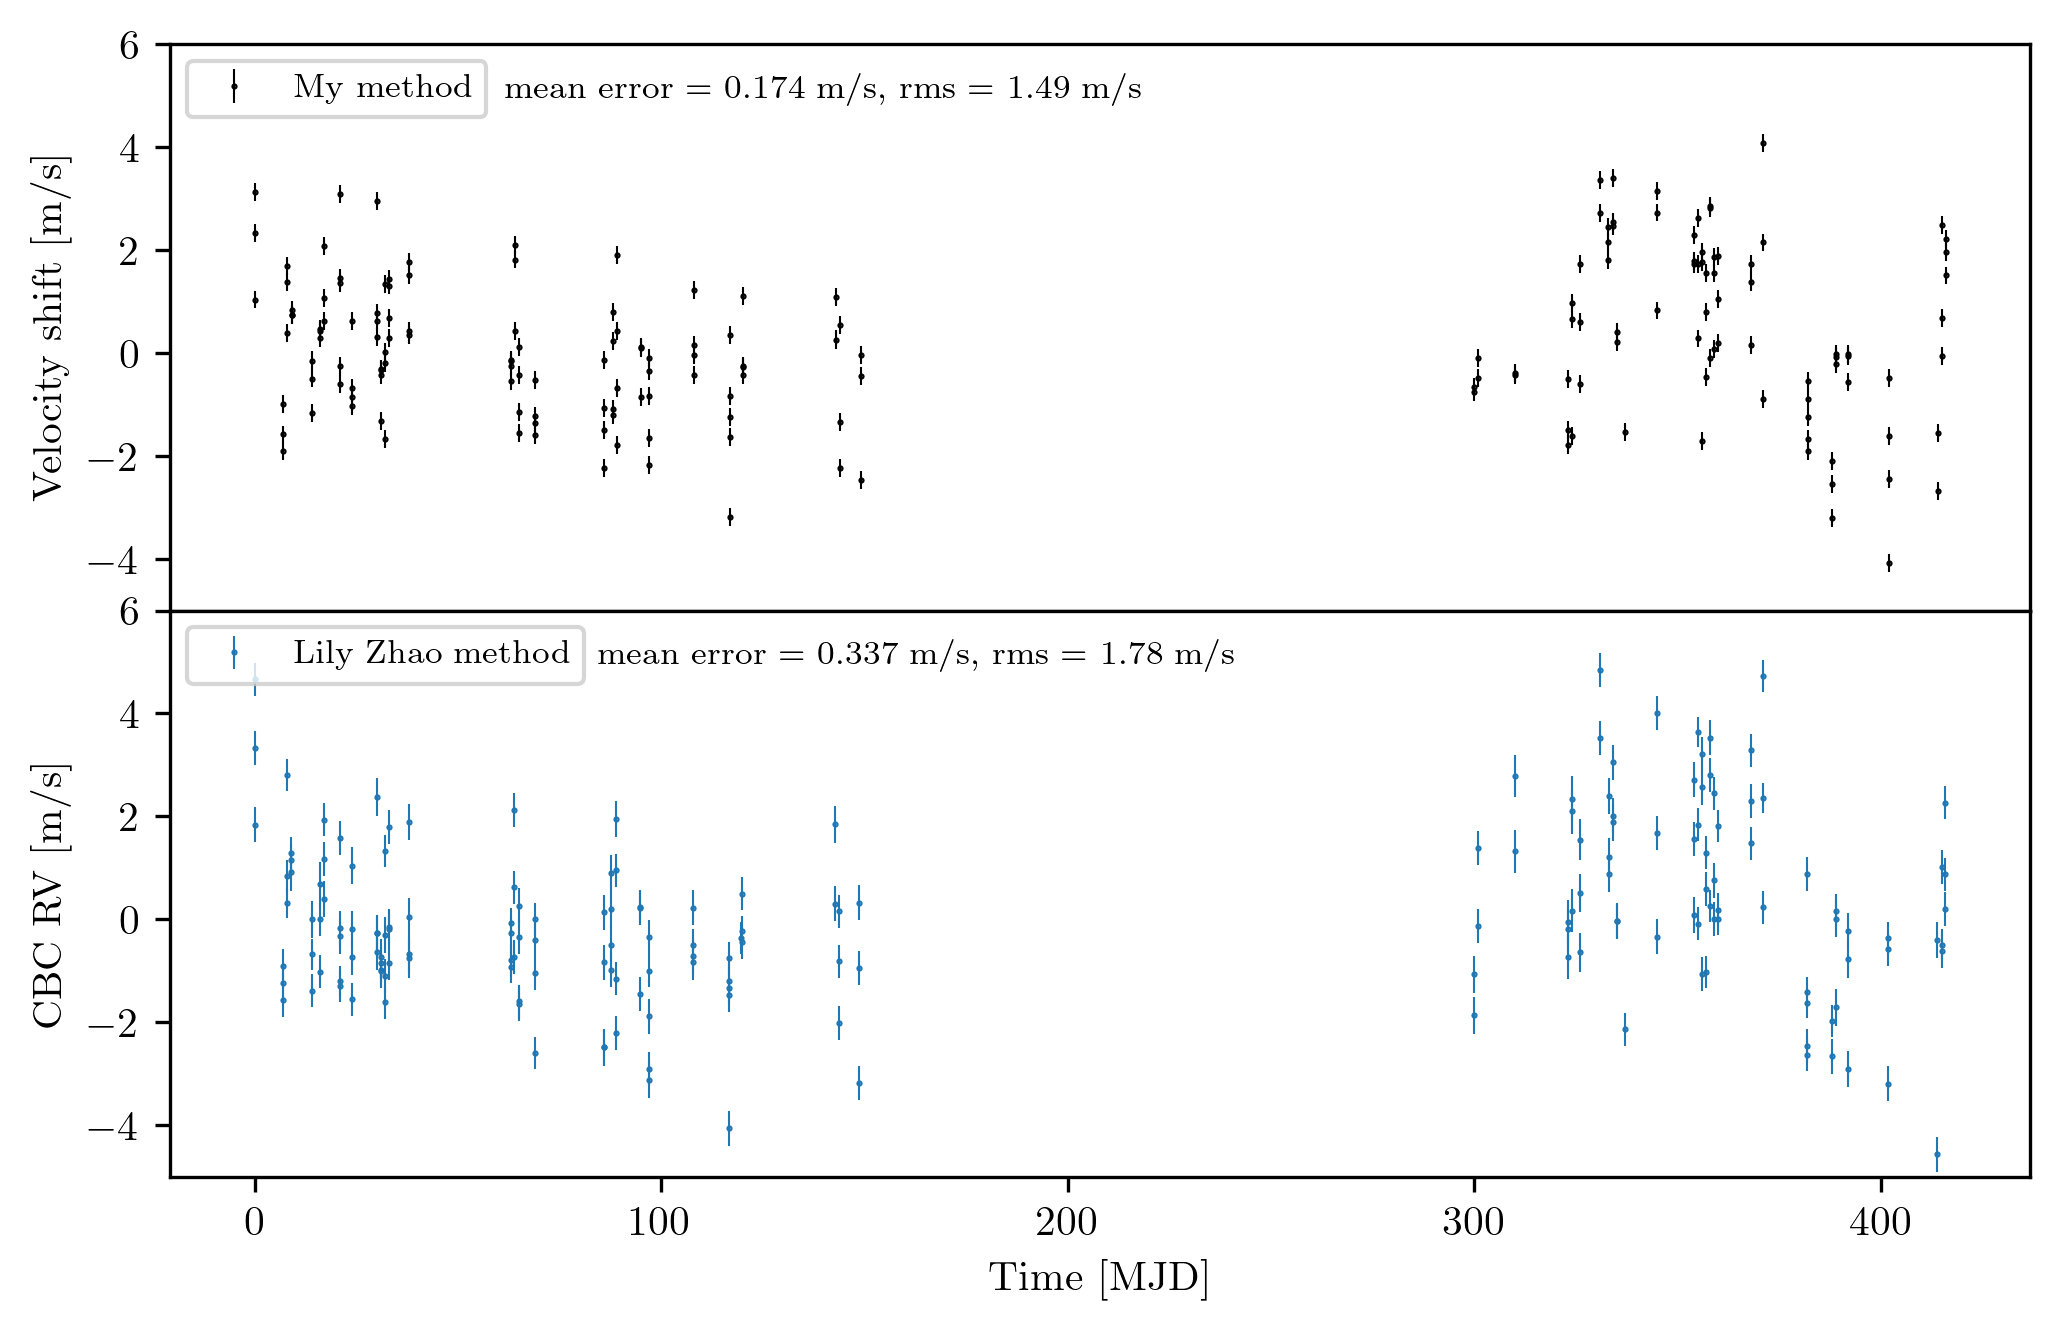

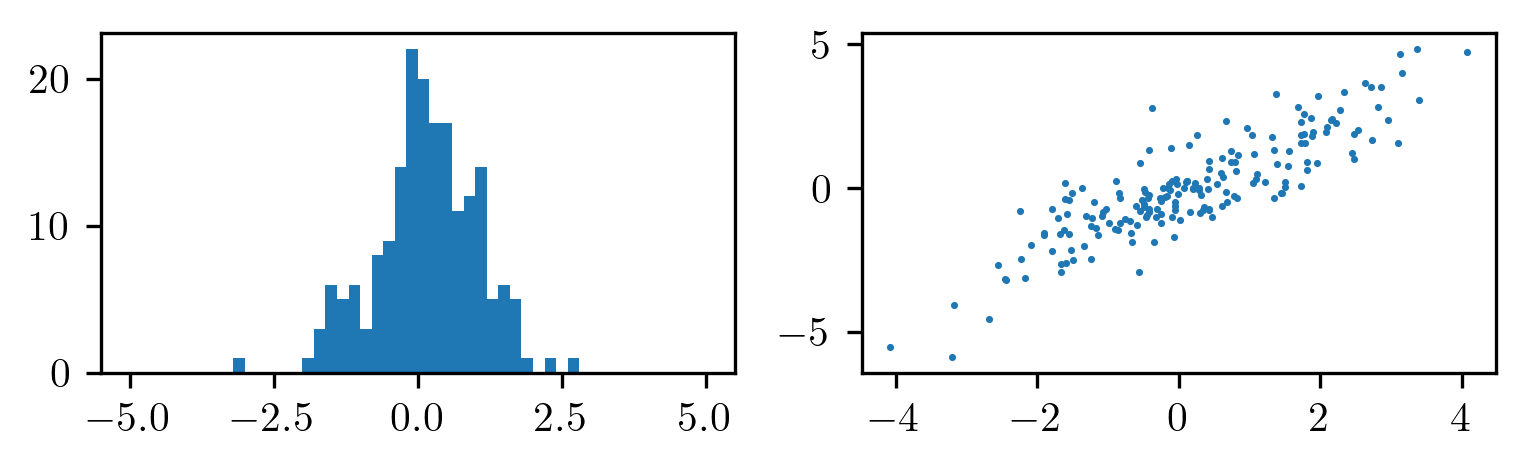

In [53]:
plot_compare_lily(final_shifts, final_shifts_err, days)

#### RV cut 12.5 m/s

In [33]:
file = "lily_data_results/all_features_all_obs_34411_ms_non_bary.npy"
# file = "lily_data_results/all_features_match2_all_files_34411_ms_bary.npy"
# file = "lily_data_results/34411_58_match2_ms_bary_err=sqrt1_dist=0.5_area=0.2.npy"
result, coords = np.load(file, allow_pickle=True)
filter_result = remove_outliers_from_result_with_rv_cut(result)
matrix = parse_matrix_results(filter_result, coords, median_err=True)
# plot_matrix(*parse_matrix_results(result, coords), plot_ratio=True)
m, final_shifts, final_shifts_err, days = matrix_reduce(*matrix, path=SPECTRA_PATH_34411, plot=False, with_date_duplicates=True)

/Users/jakobharteg/miniconda3/envs/bsc_project/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


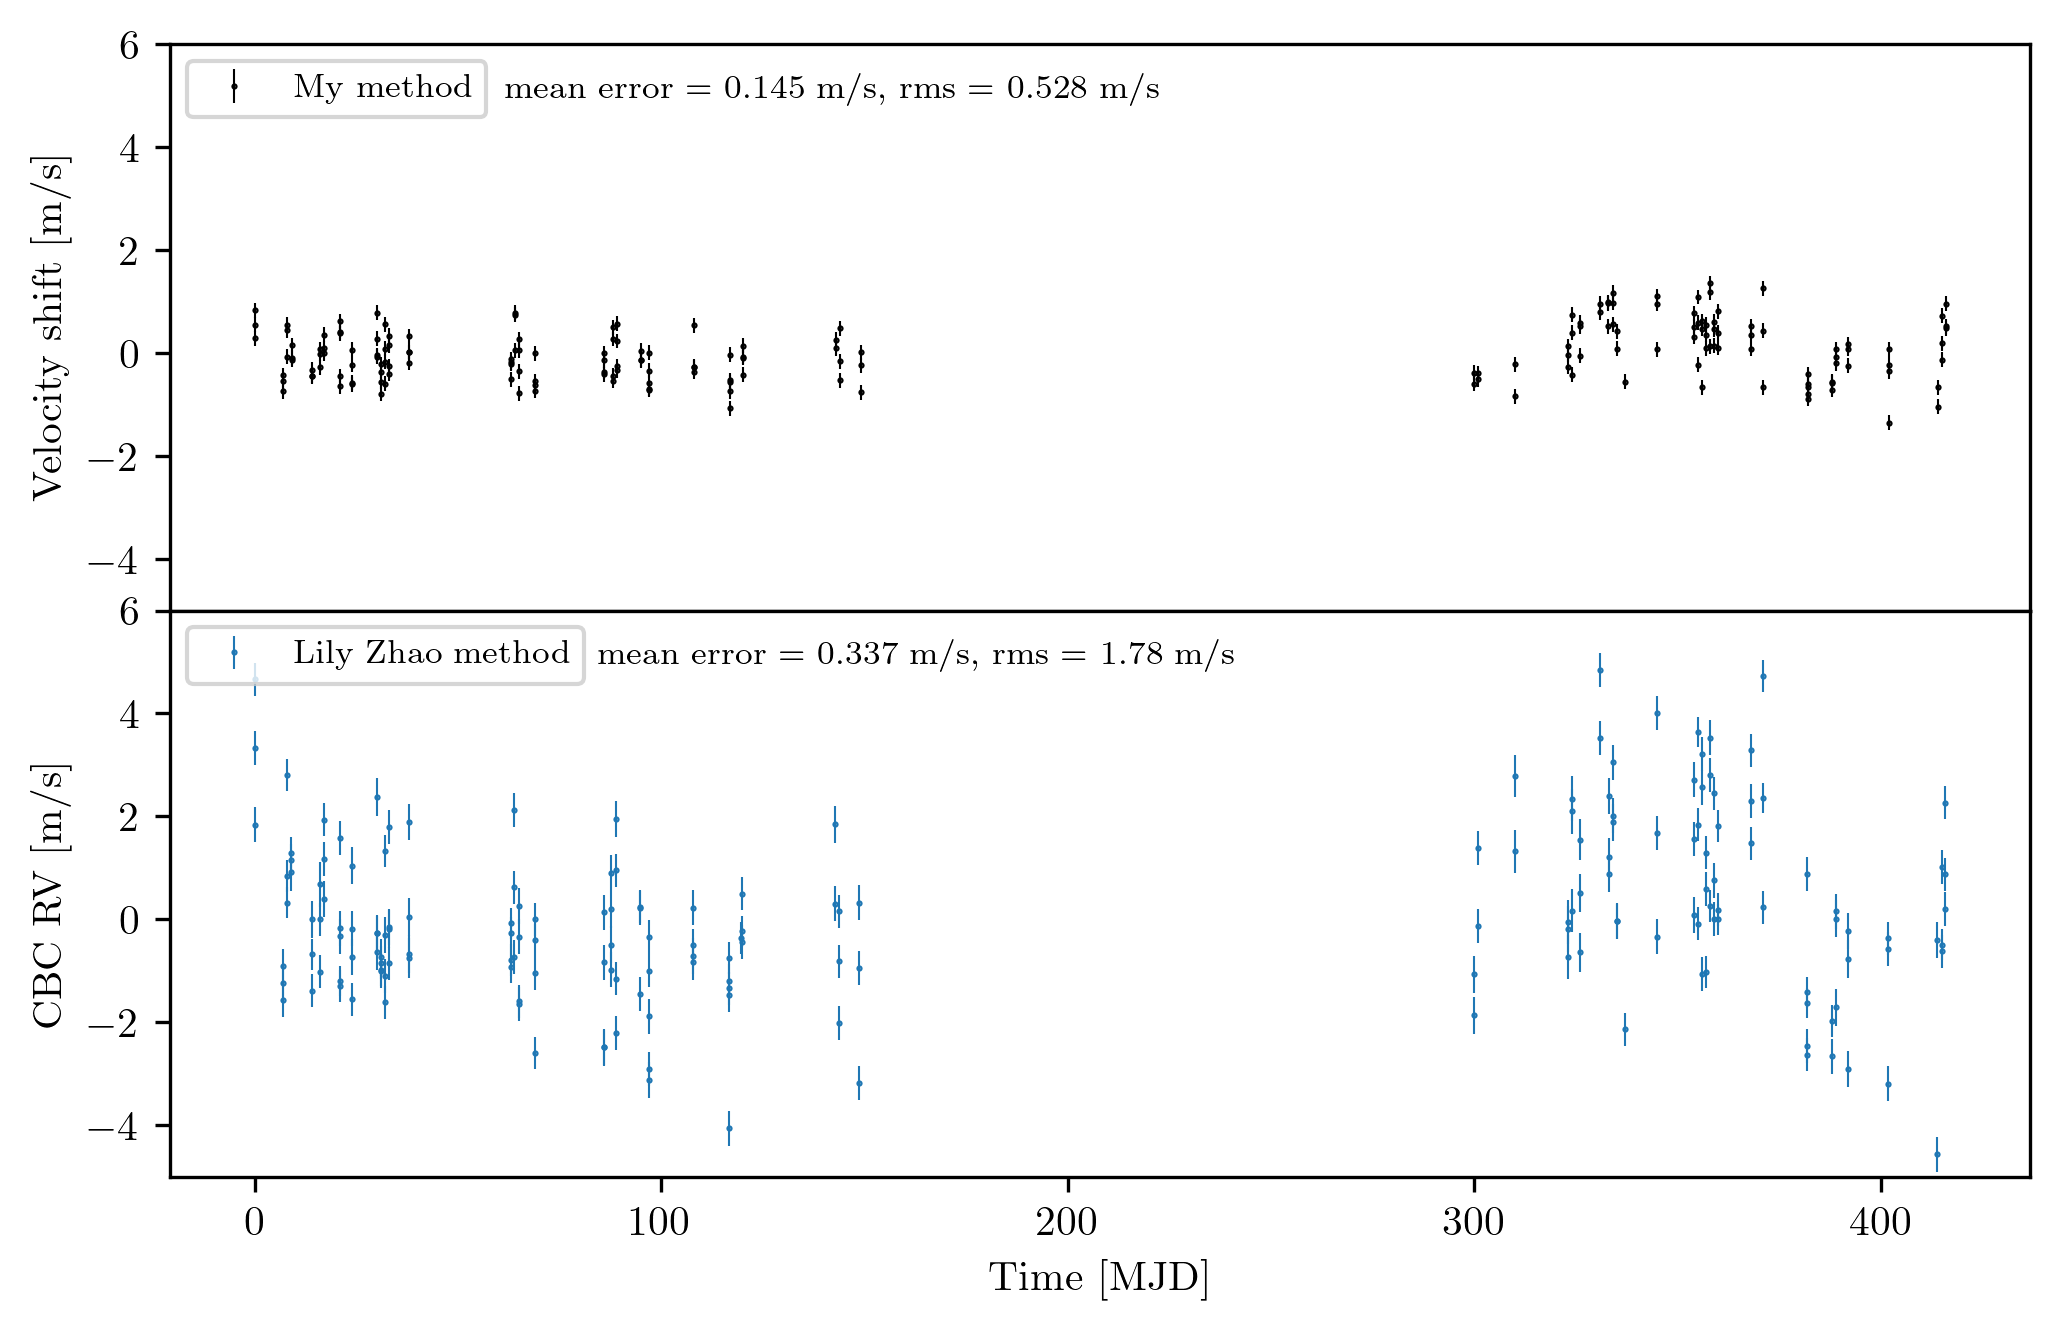

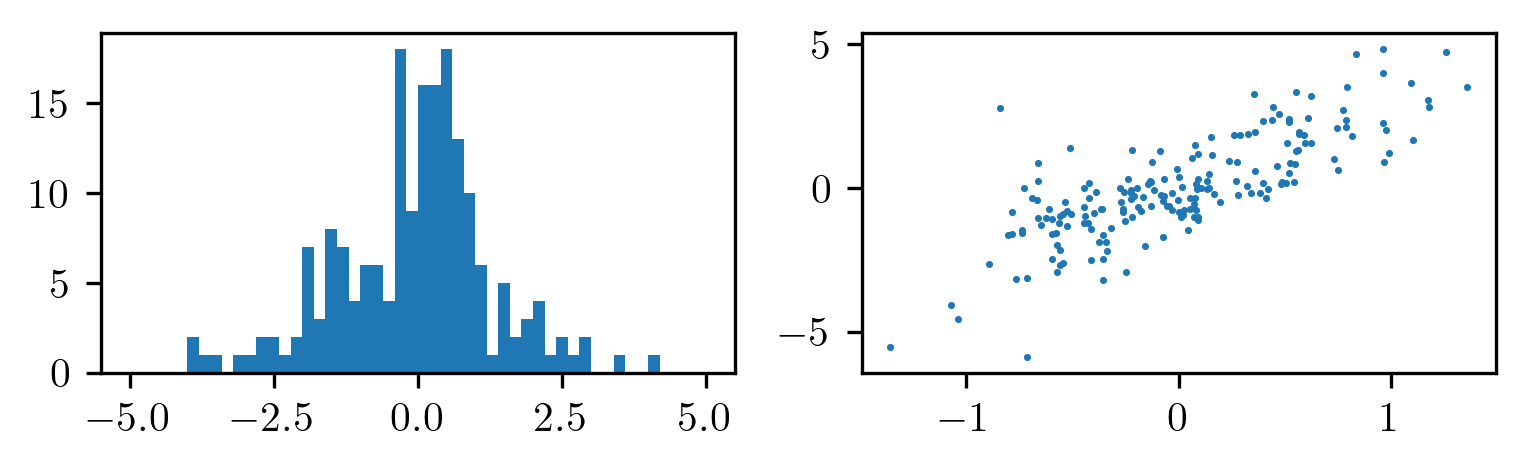

In [34]:
plot_compare_lily(final_shifts, final_shifts_err, days)

### N_points in RV shift interpolation

1255 peaks found
1211 peaks found
220 matches found


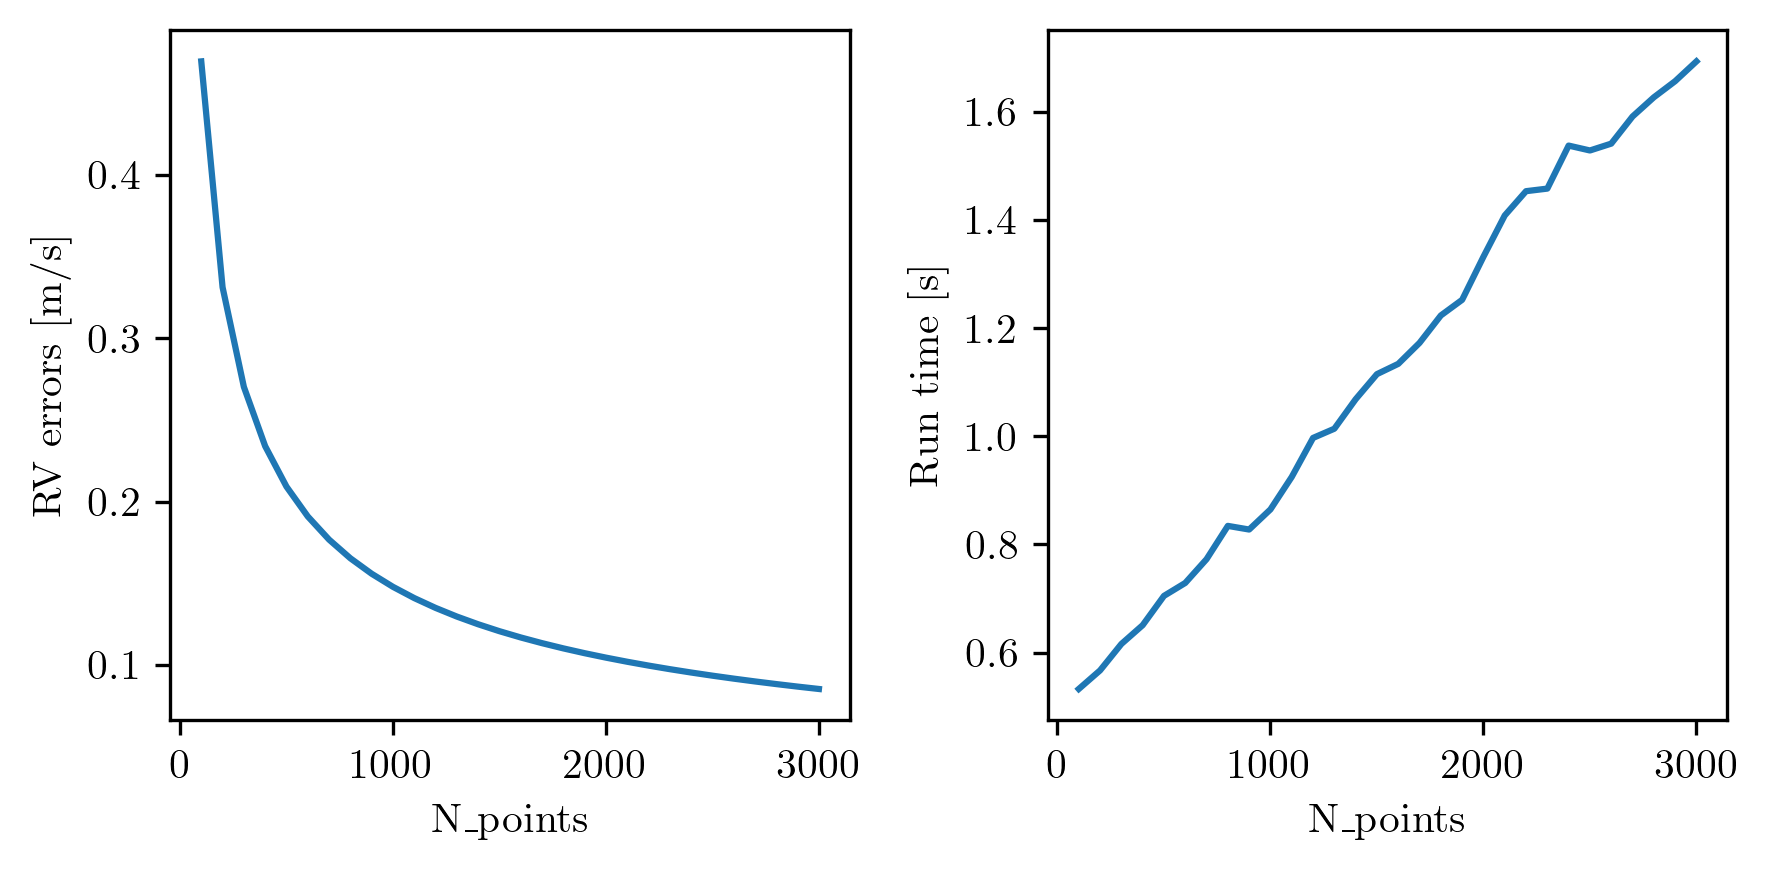

In [13]:
import time

filenames = get_spectra_filenames_without_duplicate_dates(SPECTRA_PATH_34411)
file1, file2 = filenames[1], filenames[20]
matches = find_feature_matches(find_features(file1), find_features(file2))

interp_sizes = np.linspace(100, 3000, 30)
shifts_list = []
run_times = []
for s in interp_sizes:
    start = time.time()
    shifts = compute_all_feature_shifts(matches, plot=False, interp_size=int(s))
    run_times.append(time.time() - start) # in seconds
    shifts = filter_z_test(shifts)
    shifts_list.append(shifts)

shifts_list = np.asarray(shifts_list)

err_mean = []
for r in shifts_list:
    shift_mean, shift_mean_err = weighted_mean(r[:, 0], r[:, 1])
    err_mean.append(shift_mean_err)


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6,3))

ax1.plot(interp_sizes, err_mean)
ax1.set_xlabel("N_points")
ax1.set_ylabel("RV errors [m/s]")

ax2.plot(interp_sizes, run_times)
ax2.set_xlabel("N_points")
ax2.set_ylabel("Run time [s]")

fig.tight_layout()


### RV extraction data overview

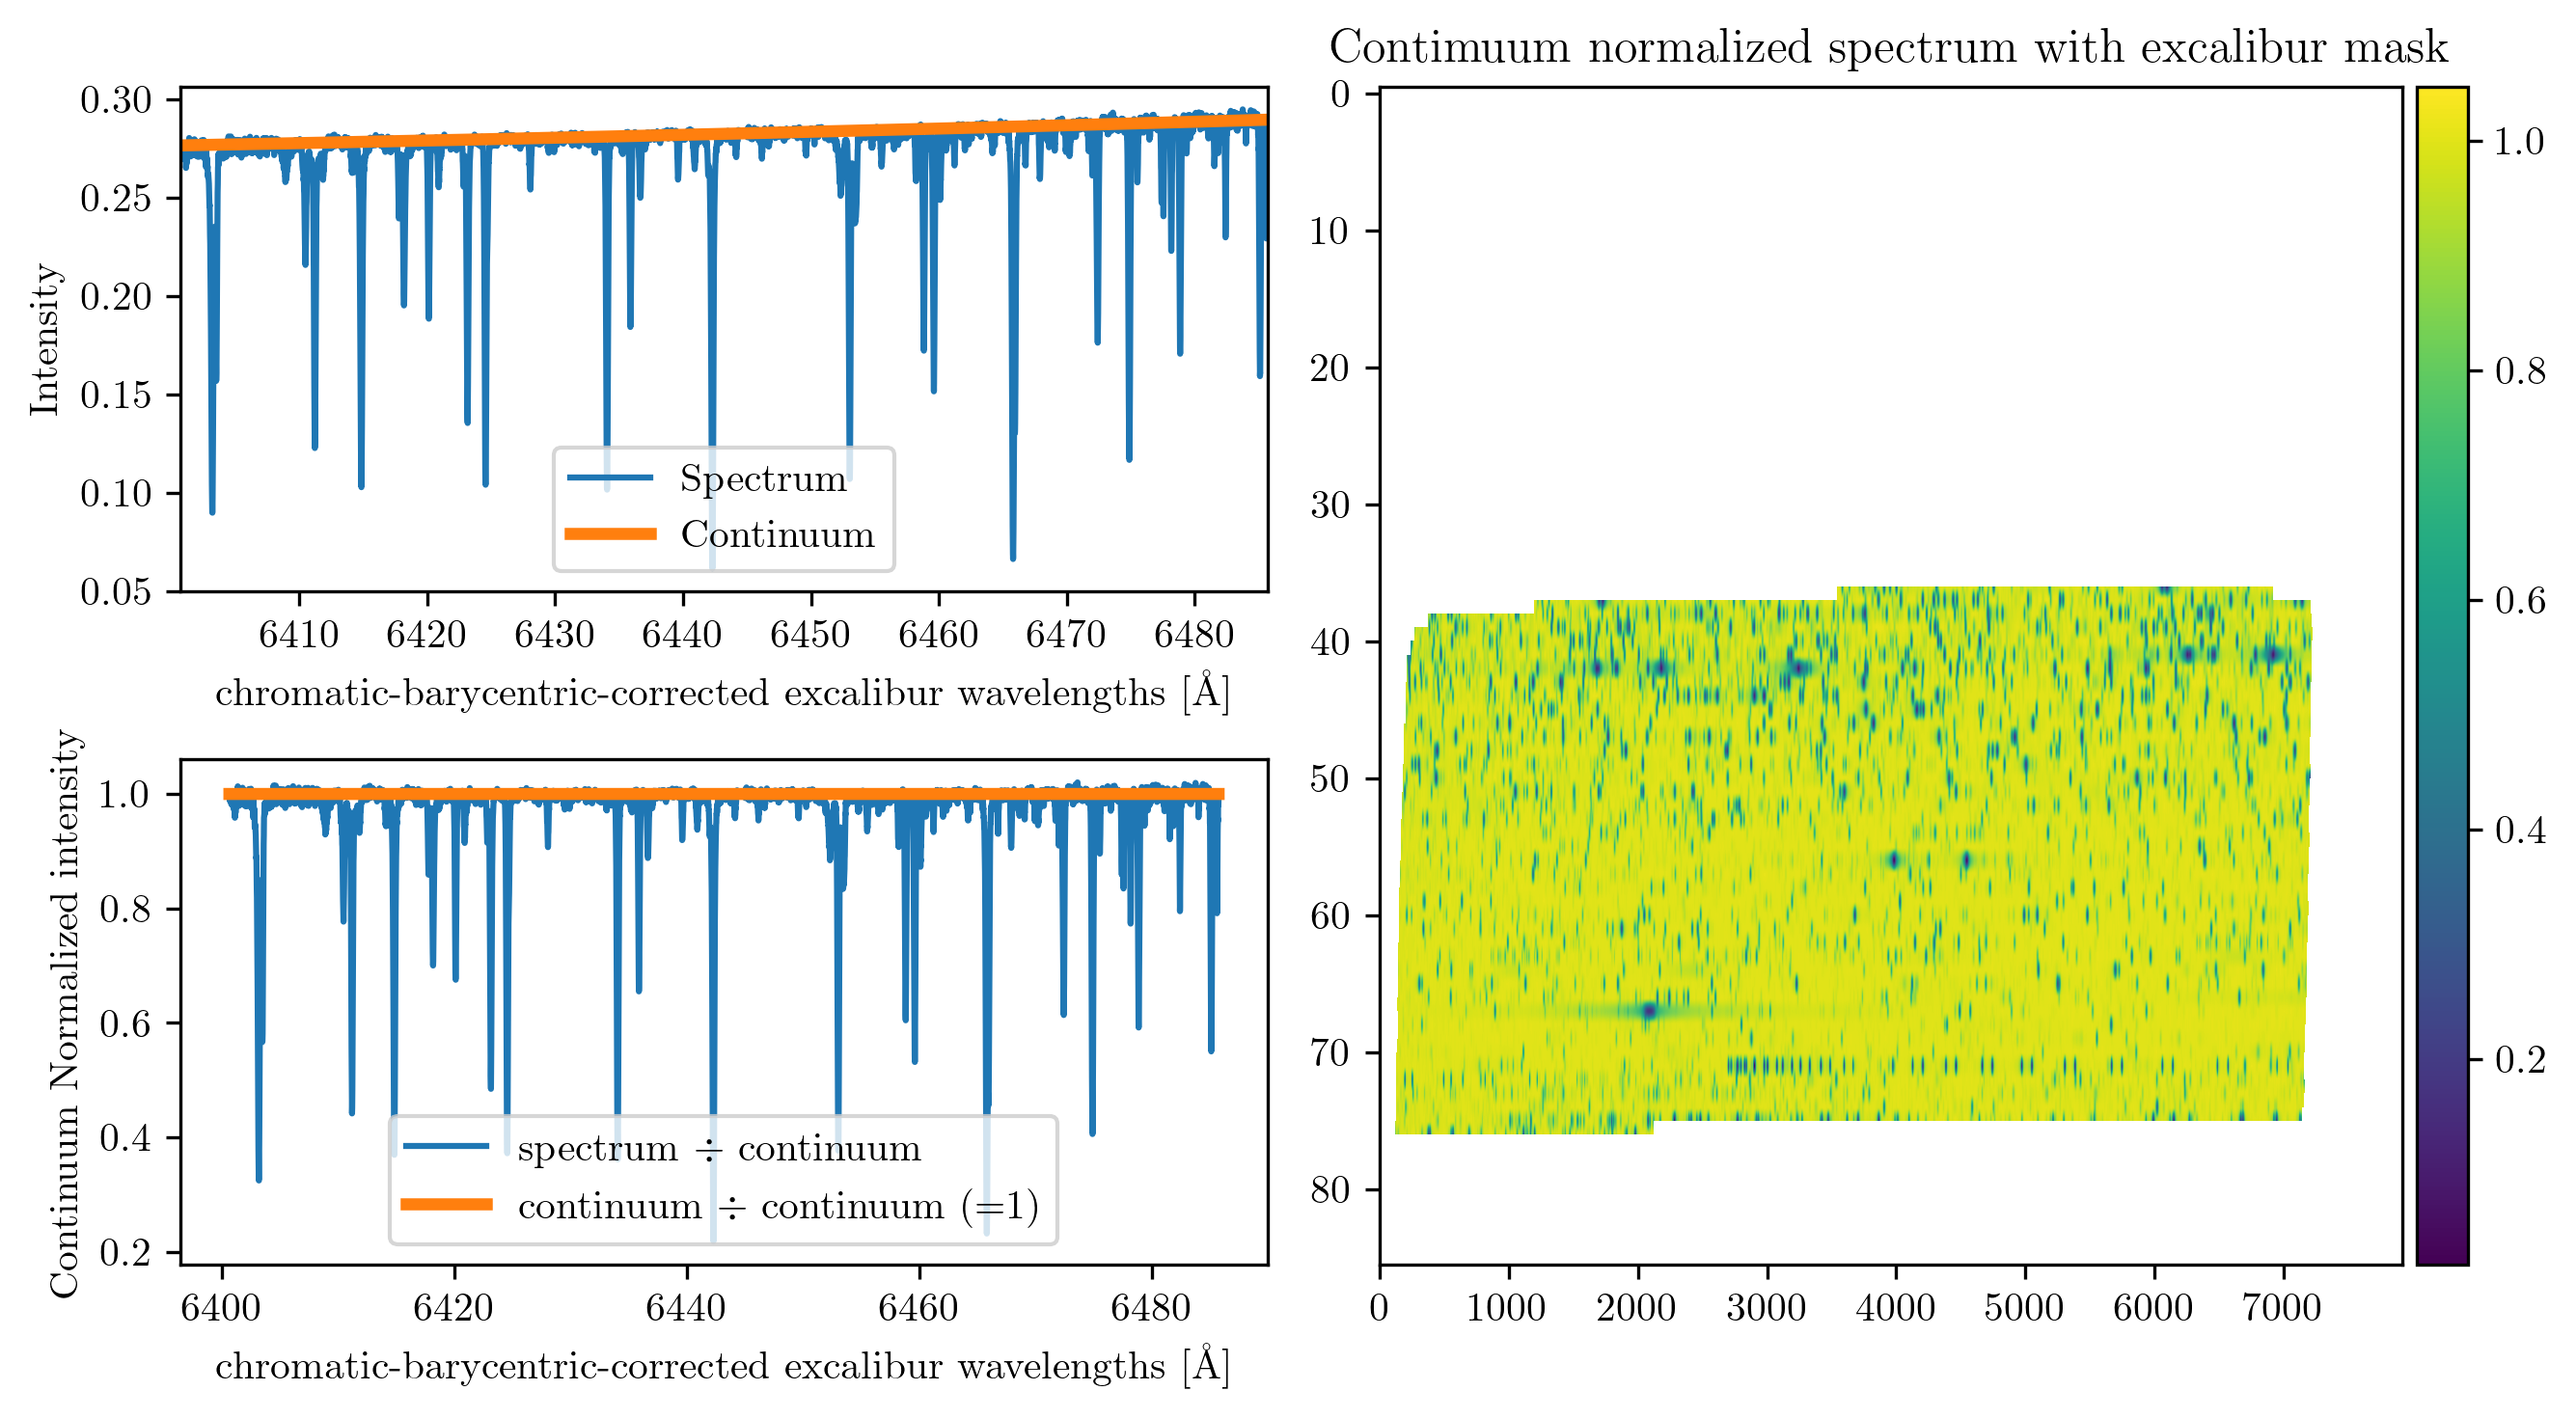

In [55]:
filenames = get_all_spectra_filenames(SPECTRA_PATH_34411)
SPECTRA_DATA = load_spectra_fits(filenames[0])

orders_pix = np.array([ SPECTRA_DATA['spectrum'][o]/SPECTRA_DATA['continuum'][o] for o in np.arange(len(SPECTRA_DATA['spectrum']))]) # create 2d array

fig = plt.figure(figsize=(9,5)) 
gs = fig.add_gridspec(2, 2) 
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0]) 
ax3 = fig.add_subplot(gs[:, 1]) 


order = 65
y, y_err, x = get_spec_wavel(SPECTRA_DATA, order, continuum_normalized=False)
ax1.plot(x, y, label="Spectrum")

# Plot continuum
excalibur_mask  = SPECTRA_DATA['EXCALIBUR_MASK'][order]
cont = SPECTRA_DATA['continuum'][order][excalibur_mask]
ax1.plot(x, cont, linewidth=3, label="Continuum")
ax1.set_xlim(min(x), max(x))

y, y_err, x = get_spec_wavel(SPECTRA_DATA, order, continuum_normalized=True)
ax2.plot(x, y, label=r"spectrum $\div$ continuum")
ax2.plot(x, cont/cont, linewidth=3, label=r"continuum $\div$ continuum (=1)")

ax1.set_xlabel("chromatic-barycentric-corrected excalibur wavelengths [Å]")
ax1.set_ylabel("Intensity")
ax1.legend(loc = "lower center")

ax2.set_xlabel("chromatic-barycentric-corrected excalibur wavelengths [Å]")
ax2.set_ylabel("Continuum Normalized intensity")
ax2.legend(loc = "lower center")

# Plot masked filter
excalibur_mask  = SPECTRA_DATA['EXCALIBUR_MASK']
orders_pix[excalibur_mask == False] = np.nan
cs = ax3.imshow(orders_pix, aspect="auto")
cax = make_axes_locatable(ax3).append_axes('right', size='5%', pad=0.05) # to make color bar same height at plot, needed when making several subplots with each colorbar
cbar = fig.colorbar(cs, ax=ax3, cax=cax)
ax3.set_title("Contimuum normalized spectrum with excalibur mask")

fig.tight_layout()

# fig.savefig("rv_data_overview.pdf", bbox_inches="tight", dpi=300)


### Matrix plots

/Users/jakobharteg/GitHub/bachelor-project/radial_velocity_functions.py:796: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  shift_mean, shift_mean_err = weighted_mean(shifts_list[shifts_valid_list == 1], shifts_err_list[[shifts_valid_list == 1]])


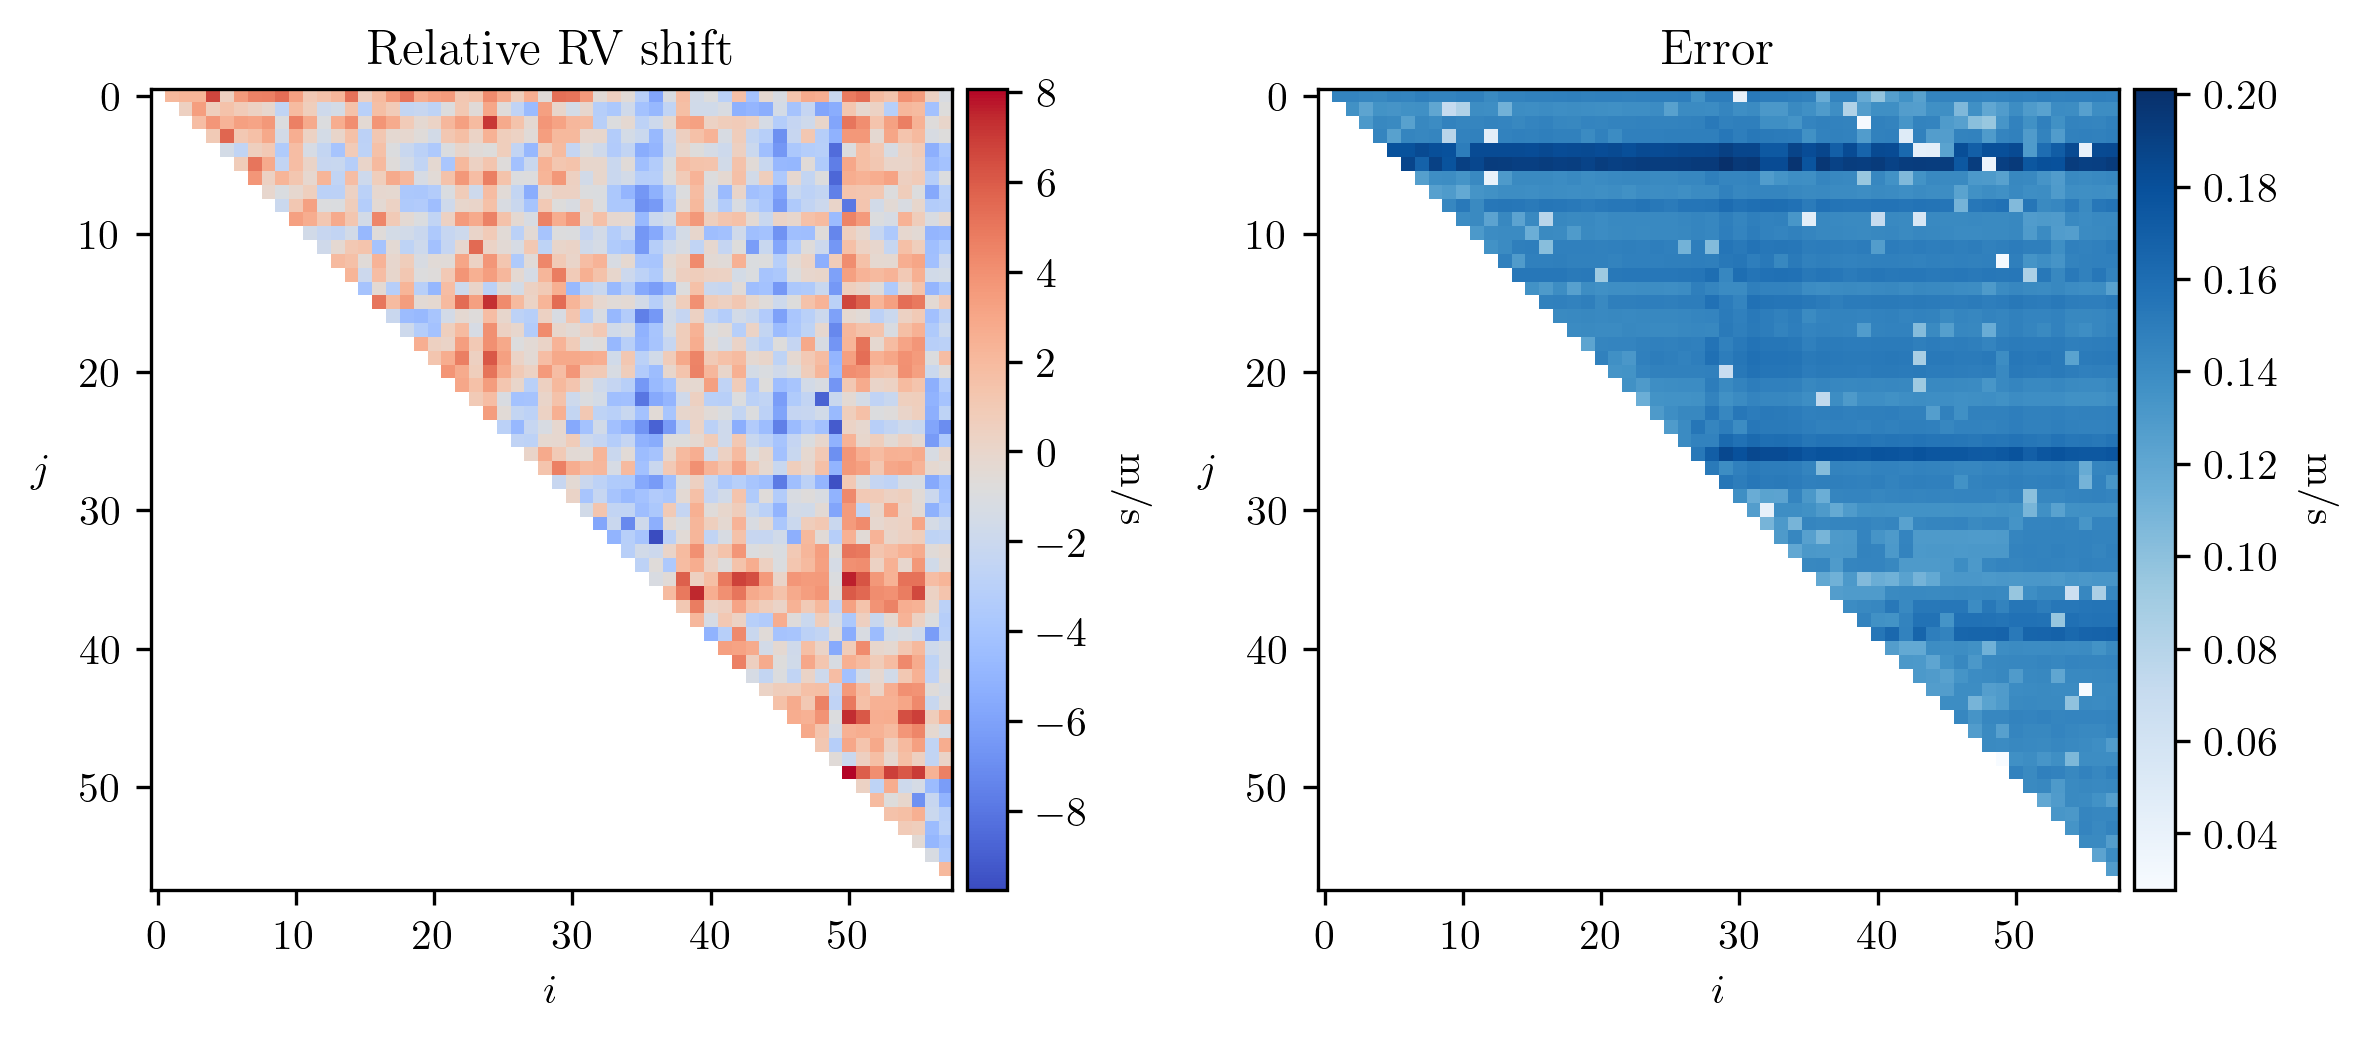

In [17]:
file = "lily_data_results/all_features_34411_ms_bary.npy"
result, coords = np.load(file, allow_pickle=True)
result = filter_z_test_result(result)
plot_matrix(*parse_matrix_results(result, coords), plot_ratio=False, kms=False)
# m, final_shifts, final_shifts_err = matrix_reduce_results_file(file, plot=True)

### Spectral Resolution

The spectral resolution given by
$$
R = \frac{\lambda}{\Delta\lambda}
$$

is ~150'000 for EXPRES. For 5000 angstrom this equals a wavelength shift of

$$
\Delta\lambda = \frac{5000 \text{Å}}{150'000} \approx 0.033 \text{Å}.
$$

A non-relativistic doppler shifted wavelength, $\lambda$, is given by

$$
    \lambda = \lambda_0 \times \Big(1 + \frac{v}{c} \Big),
$$

where $\lambda_0$ is the emited wavelength. From this we can find the velocity as

$$
    v = (\lambda / \lambda_0 - 1) \times c
$$

In [ ]:
c = 299792458   # m/s

# For a given wavelegnth, say 5000 angstrom (in meters)
λ_0 = 5000e-10

# the spectral resolution in wavelength is
Δλ = λ_0/150000

# the minimum detectable shifted wavelength is thus
λ = λ_0 + Δλ

v = (λ/λ_0 - 1) * c 
print(f"{v:.2f} m/s")


### Match selection

1266 peaks found
1255 peaks found
1037 matches found
Rejected 0 proposed matches
Rejected 0 proposed matches based on area
Rejected 501 out of 1037


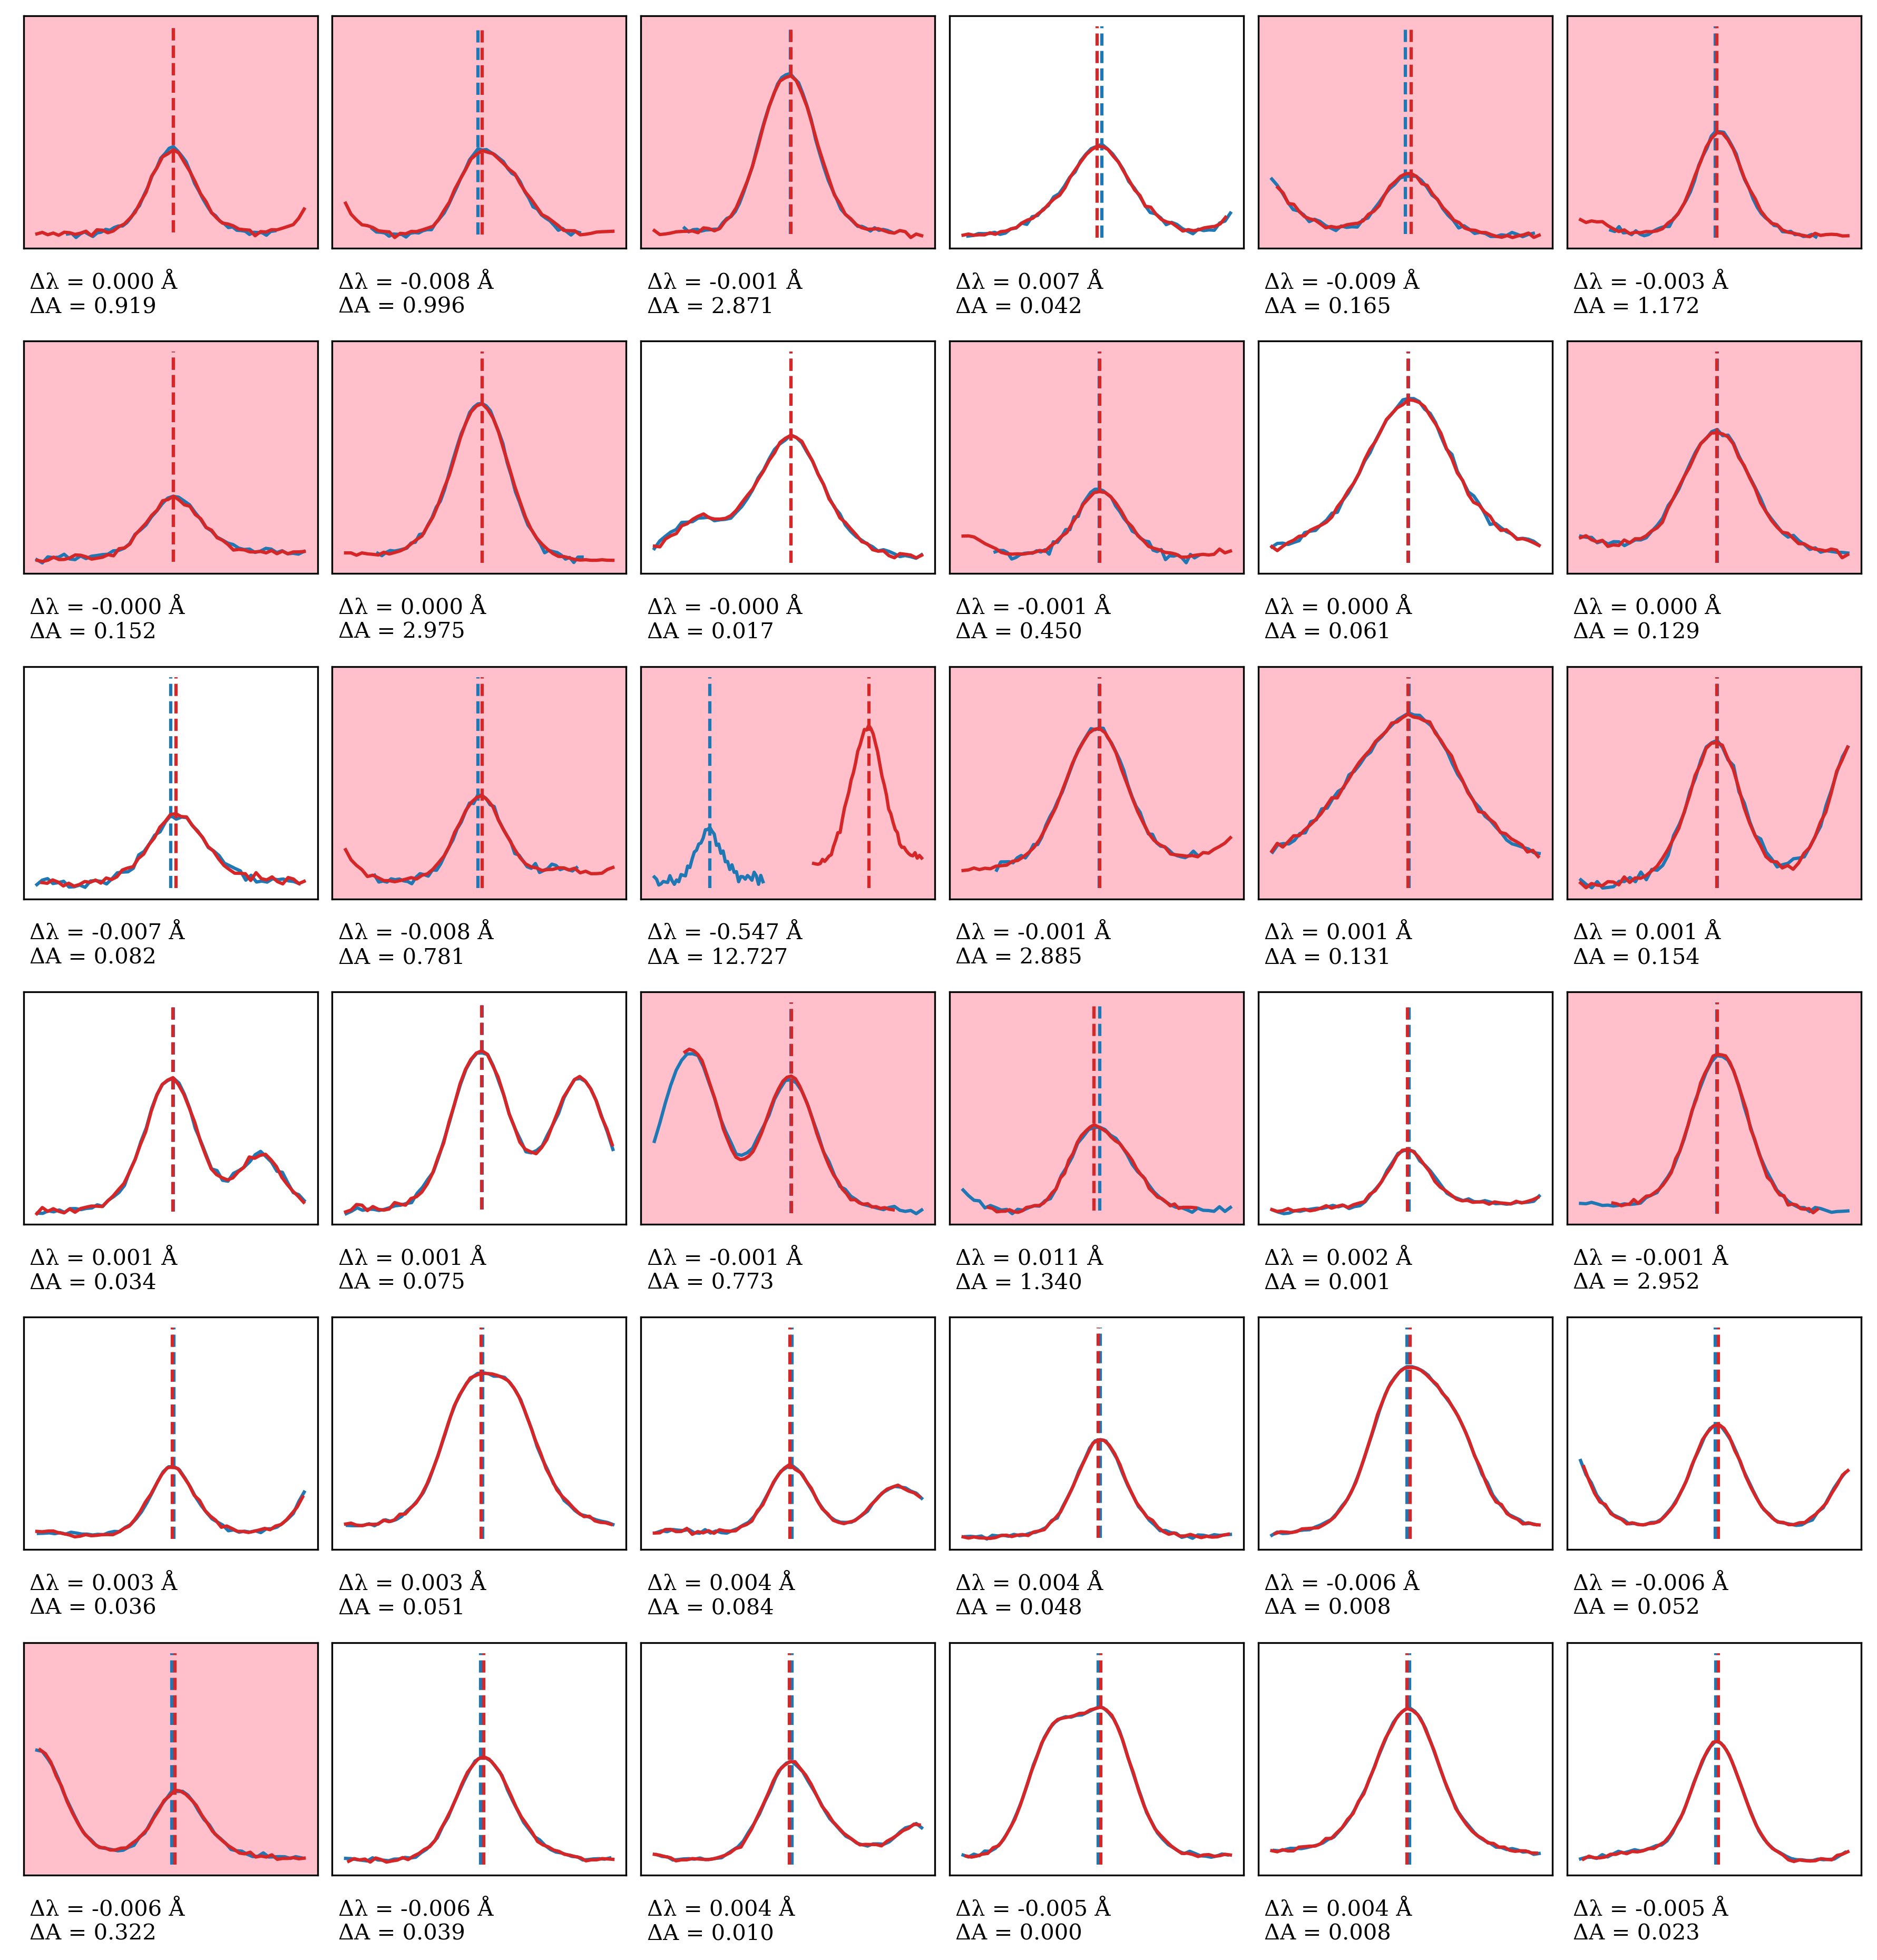

In [69]:
filenames = get_spectra_filenames_without_duplicate_dates()
features1 = find_features(filenames[0], use_bary_correction=True)
features2 = find_features(filenames[1], use_bary_correction=True)
matches_unfiltered = find_feature_matches2(features1, features2, filter=False)
mask = compute_match_filter_mask(matches_unfiltered, max_dist=0.5, max_area_diff=0.1)
fig = plot_matches(matches_unfiltered[50:150], mask[50:150], ncols=6, nrows=6, return_fig=True)
print("Rejected", len(mask[mask == False]), "out of", len(mask))
fig.savefig("feature_match_filter.pdf", bbox_inches="tight", dpi=300)